# AI TEXT GENERATION FOR BEGINNERS: CREATING AND FINE TUNING YOUR OWN SINGLISH CHATBOT

# PART 2: FINE TUNING A DIALOGPT-2 (MEDIUM) MODEL (COLAB)

Some logistical details first: This notebook ran for about 2 hours on a Colab Pro account. If you are using a free account, you'll likely have to change the settings below to a DialoGPT-small model. Due to Cuda memory limits on the free account, I couldn't fine tune a DialoGPT-medium model with my dataset. But an upgrade to Colab Pro solved the issue, alongside an upgrade to more storage space on my Google account (more on this later).

The differences in results from fine tuning a DialoGPT-small Vs DialoGPT-medium model were quite stark, for me. But if you are using a more robust dataset, then perhaps fine tuning a DialoGPT-small model would be sufficient.

Code from this notebook were lifted from the two sources below. Slight changes were made to deal with deprecated items as well as settings to suit my dataset:

** Open-Dialog Chatbots for Learning New Languages [Part 1] by [Nathan Cooper](https://github.com/ncoop57/i-am-a-nerd/blob/master/_notebooks/2020-05-12-chatbot-part-1.ipynb)

** Make your own Rick Sanchez (bot) with Transformers and DialoGPT fine-tuning by [Rostyslav Neskorozhenyi](https://colab.research.google.com/drive/15wa925dj7jvdvrz8_z3vU7btqAFQLVlG)

I won't get into the details of the DialoGPT model. You can read them [here](https://huggingface.co/transformers/model_doc/dialogpt.html).

## 1. CONNECTING TO YOUR GDRIVE / FILES FOLDER

This assumes that you've uploaded the two CSV files (train_df.csv and validate_df.csv from notebook1.0) to your Gdrive and to a folder of your choice. In this case I've named the folder Colab Notebooks for convenience. You'll need to connect to your account and this specific directory. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [ ]:
! pip -q install transformers

In [ ]:
import glob
import logging
import numpy as np
import pandas as pd
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple
import torch

from pathlib import Path

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [ ]:
# Check the GPU available on Colab, if you wish

!nvidia-smi

# 2. MODEL CONFIGURATION

There's a tonne of code from here on, but it's ok if you are unfamiliar with pytorch. The main variables to tweak are in the next cell. Subsequent code from there on runs perfectly, thanks to the previous notebook authors.

In [ ]:
# If you are using a free Colab account, switch to DialoGPT-small
# If you encounter GPU out of memory issues on Colab, reduce the batch-size. Here I brought it all the way down
# The model checkpoints will take up considerable space on your G-drive. I changed it to save every 20K-steps
# If you have more storage space, feel free to adjust the checkpoints interval

class Args():
    def __init__(self):
        self.output_dir = 'output-medium'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-medium'
        self.config_name = 'microsoft/DialoGPT-medium'
        self.tokenizer_name = 'microsoft/DialoGPT-medium'
        self.cache_dir = 'cached'
        self.block_size = 64
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 1
        self.per_gpu_eval_batch_size = 1
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 20000
        self.save_steps = 20000
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 66
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

## 2.1 CONVERT DATASET INTO FORMAT SUITABLE FOR DIALOGPT

Here we convert the dataframes - containing a response and previous contexts - into conversation strings, which are then tokenized.

In [ ]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.max_len - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [ ]:
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

# 3. TRAINING AND EVALUATION

An explanation of the technical coding details below is beyond my present knowledge, and many others can do it far better. Example: [GPT2's architecture, illustrated](http://jalammar.github.io/illustrated-gpt2/).

I'll just highlight the metric at the end of the the training-evaluation process, which is perplexity. It is a measure of the model's uncertainty in selecting the next token. Essentially, the lower the perplexity, the less uncertain the model is.

Using DialoGPT-medium on this dataset, I got a perplexity score of 1.6134. This is much lower than the scores I got from  DialoGPT-small, which ranged from 6.3 to about 5.7.

In [ ]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [ ]:
# Main runner

def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelForCausalLM.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelForCausalLM.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelForCausalLM.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

## 3.1 TRAIN THE MODEL

This could take anything from 40 minutes to about 2 hours depending on your set up and settings. I'll suggest avoiding the DialoGPT-large model unless you have access to a lot of GPUs. I couldn't fine tune the dataset on DialoGPT-large even on Colab Pro.

Expect to encounter GPU memory issues if you have a huge dataset.

In [ ]:
train_df = pd.read_csv('train_df.csv')
validate_df = pd.read_csv('validate_df.csv')


main(train_df, validate_df)

# 4. CHAT WITH THE BOT

If everything goes well, this is where the fun stuff starts and we can see if the bot can indeed hold a conversation in Singlish.

Change the "temperature" for more "creative" outputs.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-medium')
model = AutoModelForCausalLM.from_pretrained('output-medium')

# Let's chat for 5 lines
for step in range(10):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=500,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.7,
        temperature = 0.8
    )
    
    # pretty print last ouput tokens from bot
    print("Beng Bot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

## 4.1 CHAT BOT APP

Dash has released a cool chat bot app that we can easily plug in our trained model for tests. More in the next notebook.

![singlish_med2.png](https://miro.medium.com/max/1400/1*3lpKu7-FkslIkH4K9nKDRQ.png)
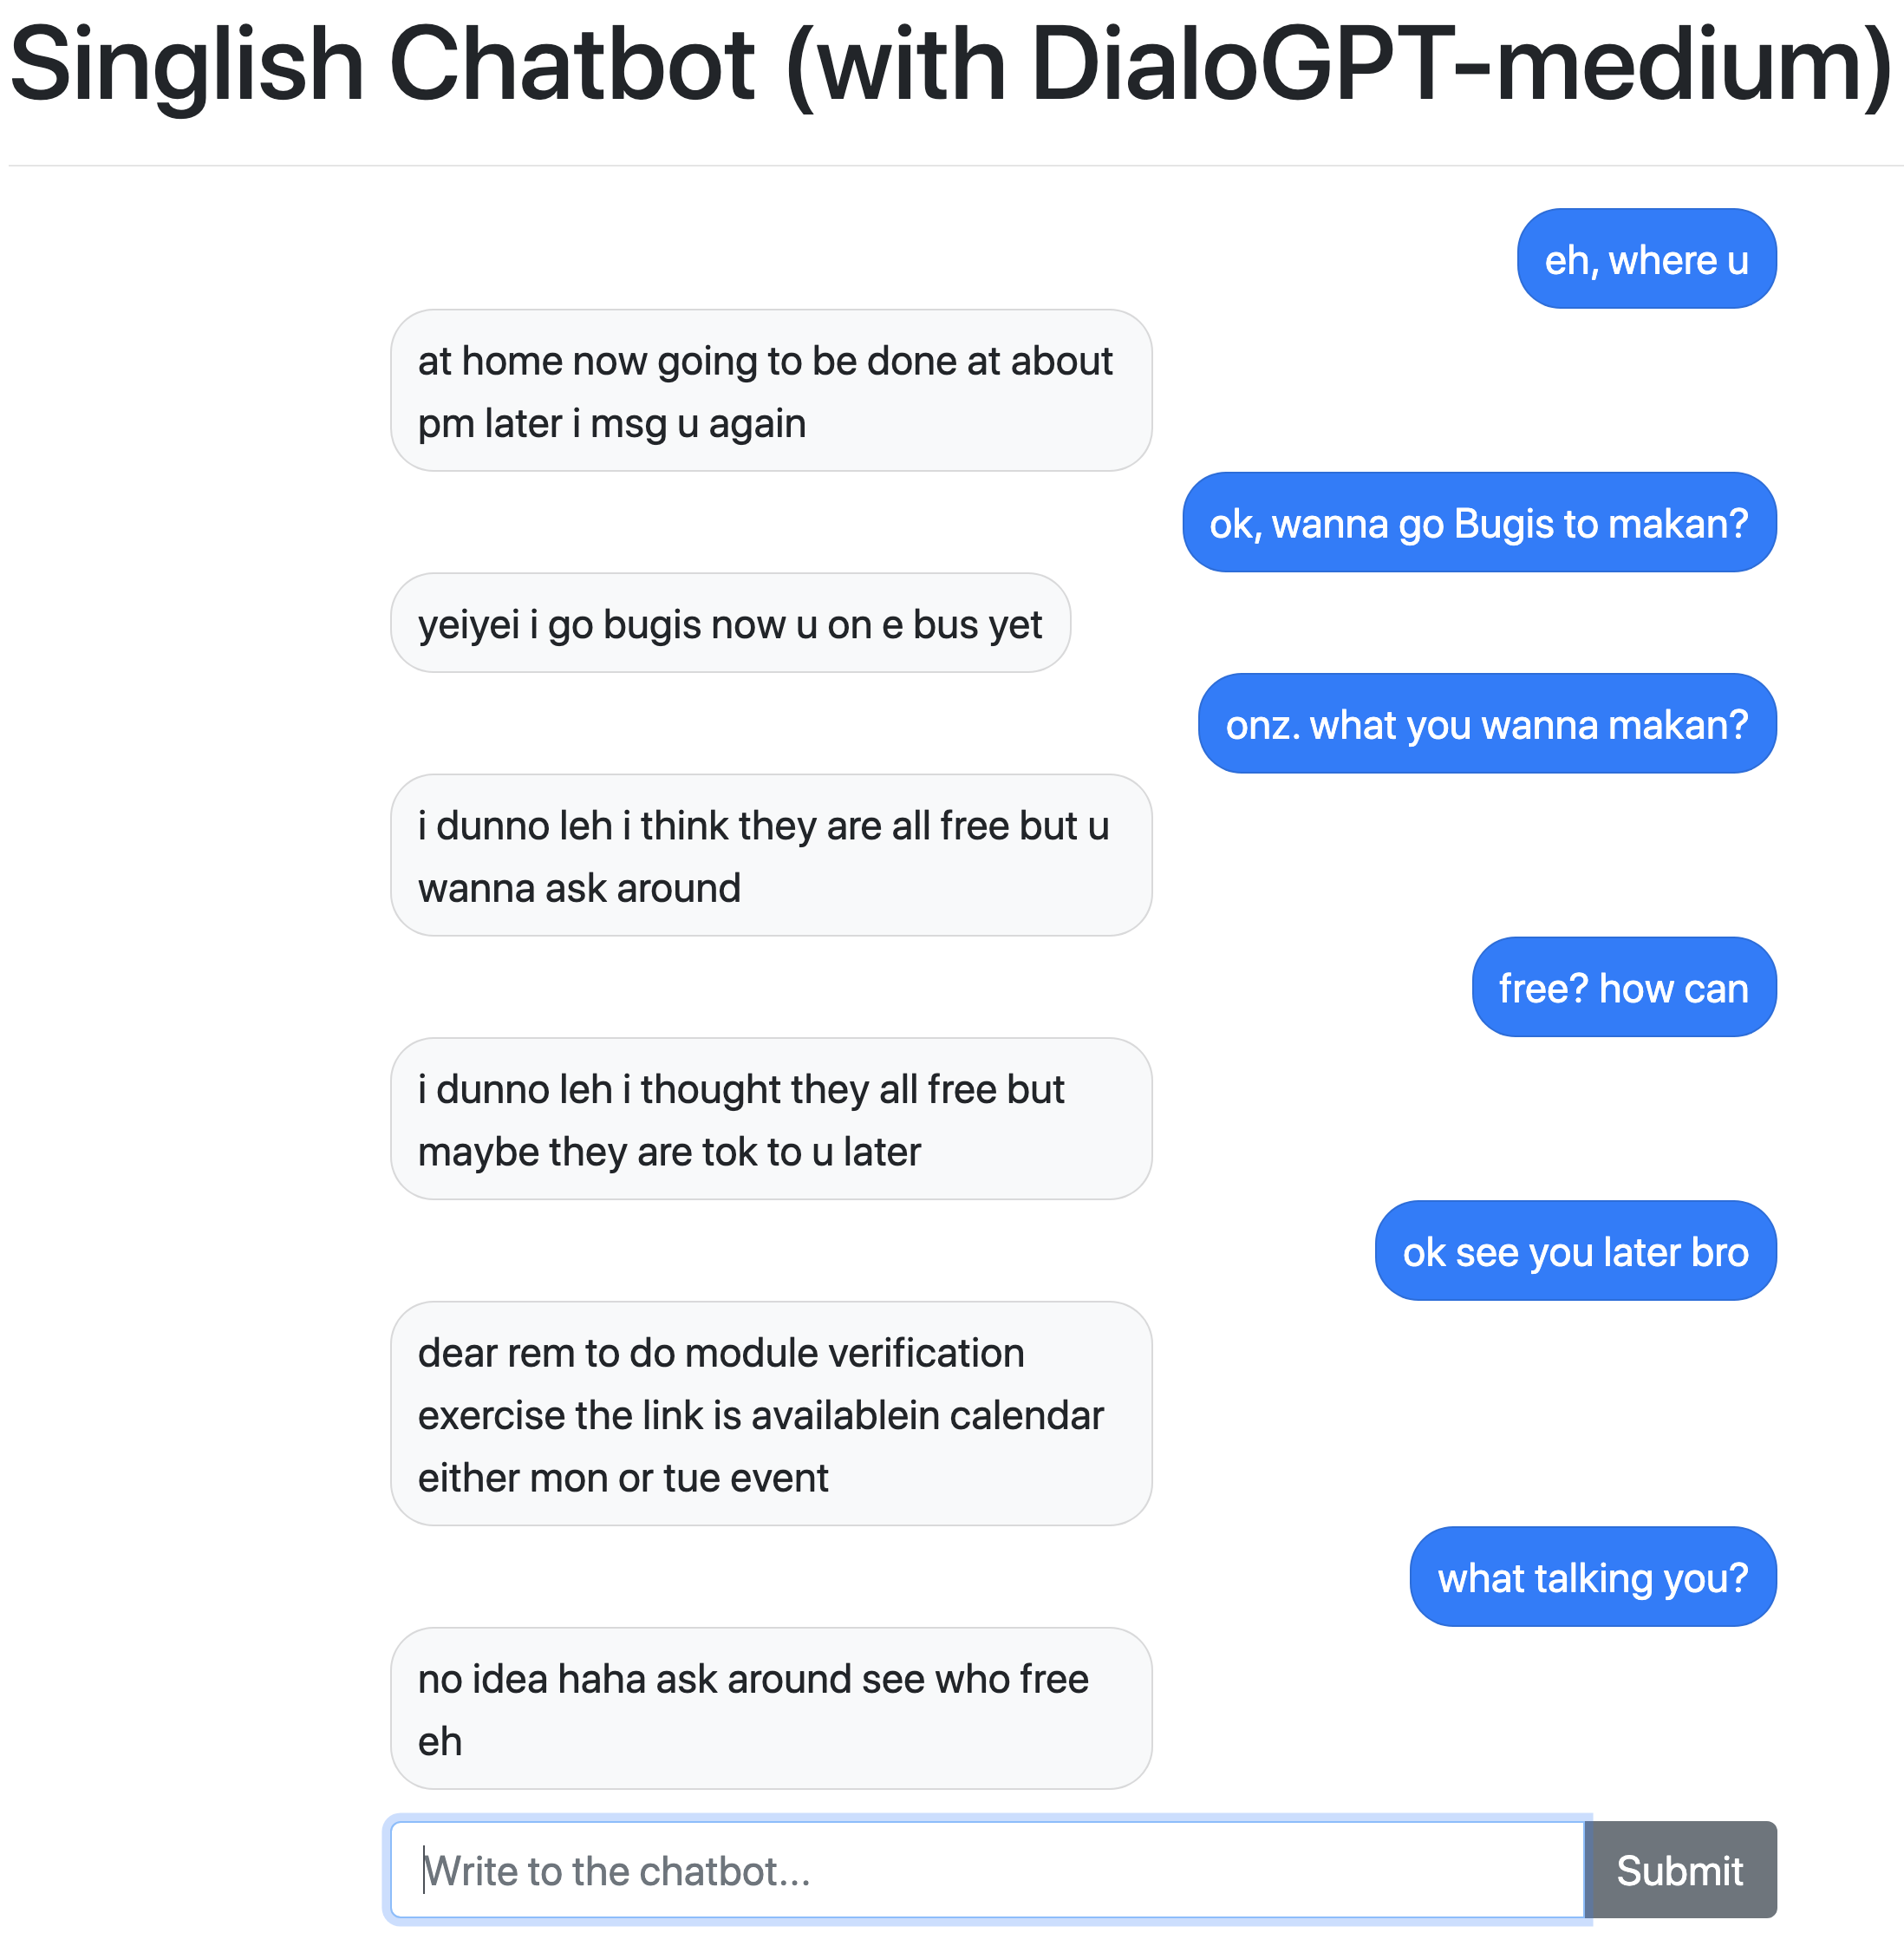